# Rover Pipeline

In [1]:
%matplotlib inline
import cv2 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc 
import glob
import imageio



## Load images data recorded by simulator

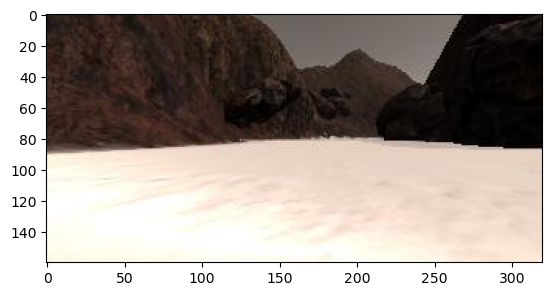

In [2]:
# given path stores images recorded during simulation 
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a recorded image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration on recorded data

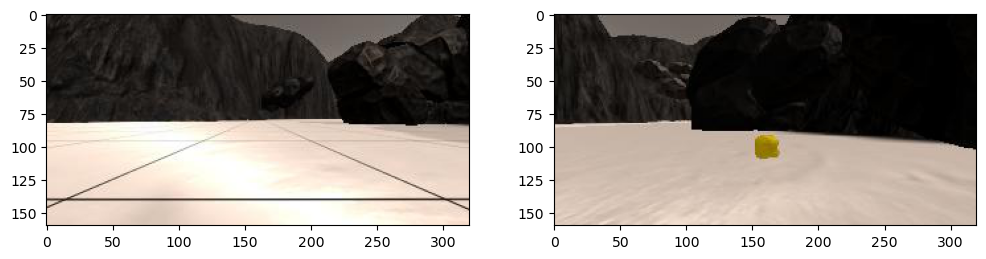

In [3]:
# Grab a grid image from our recorded data images
example_grid = '../calibration_images/example_grid1.jpg'
# Grab a sample rock image from our recorded data images
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Performing Perspective Transform

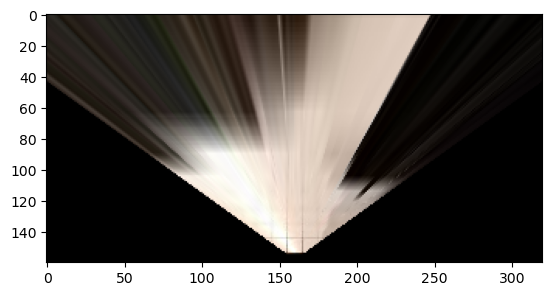

In [7]:
# each grid cell is 1 square meter in the simulator

# The function is intended to transform our prespective from camera view (grid cell in front of the rover) 
# to bird-eye view
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    
    return warped


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side

dst_size = 5 

# bottom offset to account for the fact that the bottom of the image 
bottom_offset = 6

source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped = perspect_transform(grid_img, source, destination)
plt.imshow(warped)

## Color Thresholding

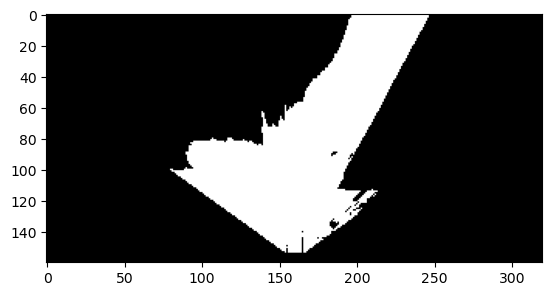

In [9]:
# here we will convert rgb (3 channel) navigable way image to a single channnel
# then perform thresholding to show navigable way in white and obstacles in  black
def nav_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    # above_thresh will now contain a boolean array with "True"
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # values above the threshold will be set to 1 (white:navigable)
    # while others will remain 0 (black:obstacle)
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = nav_thresh(warped)
plt.imshow(threshed, cmap='gray')

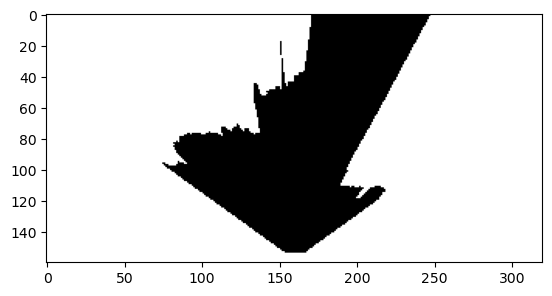

In [10]:
# here we will convert rgb (3 channel) navigable way image to a single channnel
# then perform thresholding to show obstacles in white and navigable way in  black (i.e inverse of navigable)
def obs_thresh(img, rgb_thresh=(130, 130, 130)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    
    # above_thresh will now contain a boolean array with "True"
    
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[below_thresh] = 1
    # Return the binary image
    return color_select

obstacles = obs_thresh(warped)
plt.imshow(obstacles, cmap='gray')

## Transforming the coordinates

/tmp/ipykernel_12318/3398576975.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_12318/3398576975.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


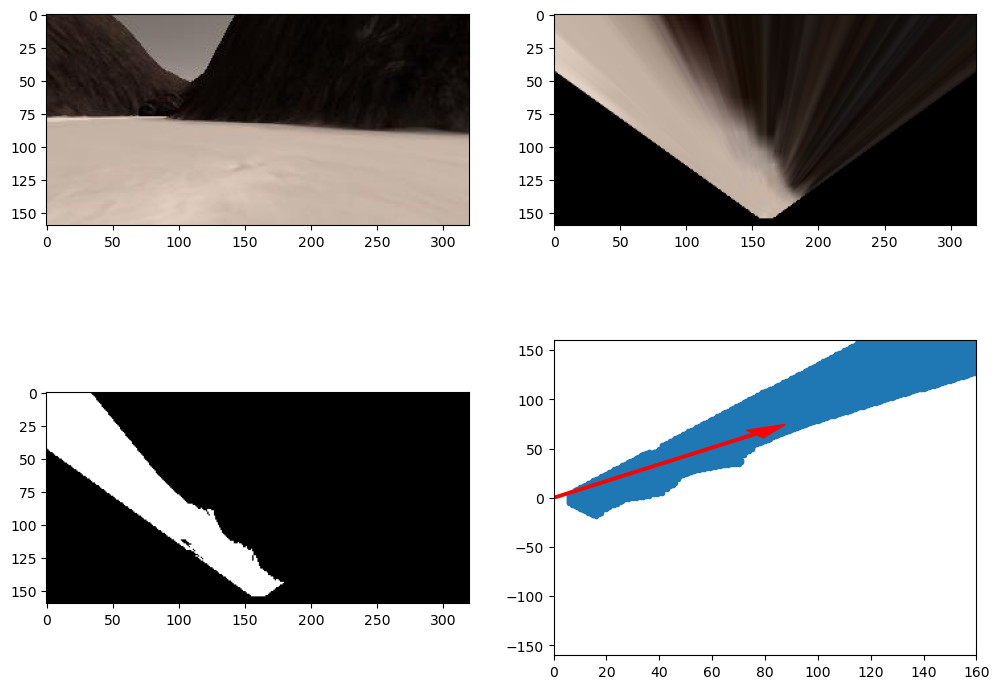

In [11]:
# function is intended to convert from image coords to rover coords
def rover_coords(binary_img):
    ypos, xpos = binary_img.nonzero()
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    
    return x_pixel, y_pixel

# function is intended to convert from rover's x,y coords to polar coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    angles = np.arctan2(y_pixel, x_pixel)
    
    return dist, angles

# function is intended to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Conversion from yaw to rads
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))                
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

# Apply a scaling and a translation
def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    
    return xpix_translated, ypix_translated


#  function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)

    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image, source, destination)
threshed = nav_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

fig.savefig('../misc/analys.jpg')

## Finding Rocks

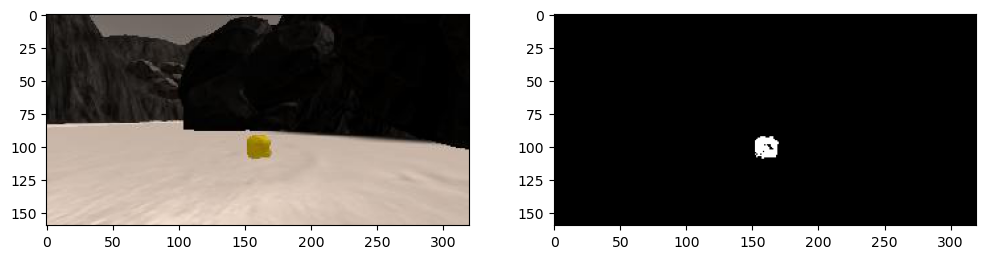

In [12]:
# function to find the rocks by thresholding
def find_rocks(img, levels=(110,110,50)):
    rockpix = ((img[:,:,0] > levels[0]) \
               & (img[:,:,1] > levels[1]) \
               & (img[:,:,2] < levels[2]))
    
    color_select = np.zeros_like(img[:,:,0])
    color_select[rockpix] = 1
    
    return color_select

rock_map = find_rocks(rock_img)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(rock_img)
plt.subplot(122)
plt.imshow(rock_map, cmap='gray')

fig.savefig('../misc/rok_threshed.jpg')

## Read in saved data and ground truth map of the world

In [14]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() 
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)


# Databucket object will store in saved data from csv file
# Worldmap is instantiated as 200 x 200 grids corresponding to a 200m x 200m space 
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# creating an instance of Databucket
data = Databucket()


/tmp/ipykernel_12318/1590987819.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
/tmp/ipykernel_12318/1590987819.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3)).astype(np.float)


## Processing the stored images

In [16]:
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    
    
    # 1) Define source and destination points for perspective transform
    dst_size = 5
    bottom_offset = 6
    src = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
    dst = np.float32([[img.shape[1]/2 - dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - bottom_offset],
                      [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - bottom_offset], 
                      [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - bottom_offset],
                      ])
    
    # 2) Apply perspective transform
    warped = perspect_transform(img, src, dst)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    navigable = nav_thresh(warped, (160, 160, 160))    # (220, 220, 200)
    obstacles = obs_thresh(warped, (130, 130, 130))     # (90, 90, 90)
    rock_samples = find_rocks(warped)
    
    # 4) Convert thresholded image pixel values to rover-centric coords
    navigable_xpix, navigable_ypix = rover_coords(navigable)
    obstacles_xpix, obstacles_ypix = rover_coords(obstacles)
    rocks_xpix, rocks_ypix = rover_coords(rock_samples)
    
    # 5) Convert rover-centric pixel values to world coords
    scale = dst_size * 2
    try:
        
        xpos, ypos = data.xpos[data.count], data.ypos[data.count]
        yaw = data.yaw[data.count]
    except IndexError:
        xpos, ypos = data.xpos[data.count-1], data.ypos[data.count-1]
        yaw = data.yaw[data.count-1]
    worldmap_size = data.worldmap.shape[0]
    navigable_x_world, navigable_y_world = pix_to_world(
        navigable_xpix, navigable_ypix,
        xpos, ypos, yaw, worldmap_size, scale)
    obstacles_x_world, obstacles_y_world = pix_to_world(
        obstacles_xpix, obstacles_ypix,
        xpos, ypos, yaw, worldmap_size, scale)
    rocks_x_world, rocks_y_world = pix_to_world(
        rocks_xpix, rocks_ypix,
        xpos, ypos, yaw, worldmap_size, scale)
    
    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obstacles_y_world, obstacles_x_world, 0] = 255
    data.worldmap[rocks_y_world, rocks_x_world, 1] = 255
    data.worldmap[navigable_y_world, navigable_x_world, 2] = 255

    # 7) Make a mosaic image, below is some example code
    
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
    output_image[0:img.shape[0], 0:img.shape[1]] = img

    
    warped = perspect_transform(img, source, destination)
    
    output_image[0:img.shape[0], img.shape[1]:] = warped

    
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)

    
    cv2.putText(output_image,"Navigable: Blue/Pink; Obstacle: Red; Sample Rock: Yellow", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)

    if data.count < len(data.images) - 1:
        data.count += 1 
    
    return output_image

## Video from our processed image data
  

In [17]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=60) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
CPU times: user 3.58 s, sys: 87.2 ms, total: 3.67 s
Wall time: 4.56 s


In [18]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))